# Breast cancer circulating tumour cell classification
## 2.3. Deep Neural Network (DNN)

Importing necessary libraries

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, csc_matrix
import joblib

# scikit-learn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import RocCurveDisplay, balanced_accuracy_score, roc_auc_score, accuracy_score, make_scorer, classification_report, ConfusionMatrixDisplay

plt.style.use('default')

## Import CTC training and validation data

In [3]:
store = pd.HDFStore(os.path.join(os.pardir, 'data', 'ctc_split_datasets.h5'), mode='r')

X_train, X_valid = store["X_train"], store["X_valid"]
y_train, y_valid = store["y_train"], store["y_valid"]

store.close()
del store

View information about the data

In [4]:
X_train.info(), X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230 entries, BRx_42_1_10_20_CTC_jor to X245_CTC_mar
Columns: 52762 entries, ENSG00000223972.5 to ENSG00000210196.2
dtypes: float64(48523), int64(4239)
memory usage: 92.6+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, Brx116_1_SC1_092414_CTC_ebr to BRx_82_1_9_29_CTC_jor
Columns: 52762 entries, ENSG00000223972.5 to ENSG00000210196.2
dtypes: float64(48523), int64(4239)
memory usage: 16.1+ MB


(None, None)

In [5]:
y_train.info(), y_valid.info()

<class 'pandas.core.series.Series'>
Index: 230 entries, BRx_42_1_10_20_CTC_jor to X245_CTC_mar
Series name: state
Non-Null Count  Dtype
--------------  -----
230 non-null    int64
dtypes: int64(1)
memory usage: 3.6+ KB
<class 'pandas.core.series.Series'>
Index: 40 entries, Brx116_1_SC1_092414_CTC_ebr to BRx_82_1_9_29_CTC_jor
Series name: state
Non-Null Count  Dtype
--------------  -----
40 non-null     int64
dtypes: int64(1)
memory usage: 640.0+ bytes


(None, None)

Convert gene data into a sparse matrix to reduce memory and improve performance

In [7]:
X_train_csc = csc_matrix(X_train.values.astype(np.float32))
X_train_csc

<230x52762 sparse matrix of type '<class 'numpy.float32'>'
	with 1248558 stored elements in Compressed Sparse Column format>

In [8]:
X_train_csr = X_train_csc.tocsr()
X_train_csr

<230x52762 sparse matrix of type '<class 'numpy.float32'>'
	with 1248558 stored elements in Compressed Sparse Row format>

In [9]:
X_valid_csr = csr_matrix(X_valid.astype(np.float32))
X_valid_csr

<40x52762 sparse matrix of type '<class 'numpy.float32'>'
	with 216275 stored elements in Compressed Sparse Row format>

Starting with creating 'linear' kernel, fitting the training data and checking mean accuracy for the testing data.

### Results functions
Define functions to measure model training and validation results

In [8]:
"""
    Prints and displays metrics used to evaluate the model.
"""
def classifier_results(classifier_name:str, dataset_name:str, y, y_pred, y_pred_proba) -> None:    

    print(f"Mean accuracy ({dataset_name}):", accuracy_score(y, y_pred))
    print(f"Mean balanced accuracy({dataset_name}): ", balanced_accuracy_score(y, y_pred))
    print(f"Mean roc auc({dataset_name}): ", roc_auc_score(y, y_pred_proba))
    
    
    RocCurveDisplay.from_predictions(y, y_pred_proba, plot_chance_level=True, drop_intermediate=False)
    plt.title(f"{classifier_name} ROC Curve {dataset_name}")
    plt.show()
    
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"{classifier_name} Confusion Matrix {dataset_name}")
    plt.show()
    
    print(classification_report(y, y_pred))


"""
    Trains, validates and displays results of a DNN model with provided estimator(model).
"""
def classifier_results_from_estimator(estimator) -> None:
    y_train_pred = estimator.predict(X_train_csr)
    y_train_pred_proba = estimator.predict_proba(X_train_csr)[:,1]
    
    y_valid_pred = estimator.predict(X_valid_csr)
    y_valid_pred_proba = estimator.predict_proba(X_valid_csr)[:,1]
    
    classifier_results("Deep Neural Network", "Training", y_train, y_train_pred, y_train_pred_proba)
    classifier_results("Deep Neural Network", "Validation", y_valid, y_valid_pred, y_valid_pred_proba)

    
"""
    Creates, trains, validates and displays results of a DNN model with provided params.
    Returns the model.
""" 
def mlp_classifier_results(params) -> MLPClassifier:
    mlp = MLPClassifier(**params)
    mlp.fit(X_train_csc, y_train)
        
    
    y_train_pred = mlp.predict(X_train_csr)
    y_train_pred_proba = mlp.predict_proba(X_train_csr)[:,1]
    
    y_valid_pred = mlp.predict(X_valid_csr)
    y_valid_pred_proba = mlp.predict_proba(X_valid_csr)[:,1]
    
    classifier_results("Support Vector Machine", "Training", y_train, y_train_pred, y_train_pred_proba)
    classifier_results("Support Vector Machine", "Validation", y_valid, y_valid_pred, y_valid_pred_proba)
    
    return mlp

## Define functions using Grid Search Cross-Validation

Define the parameters that divide the samples so that they are always drawn identically

In [11]:
random_state = 0
rng = np.random.RandomState(random_state)
cv_kFold = KFold(n_splits=7, shuffle=True, random_state=random_state)

Define functions to perform Grid Search CV based on model parameters

In [12]:
"""
    Conducts grid search for cross-validation on the training dataset with given parameters for search and model.
    Prints classification results for training and validation.
    Prints best params from grid search.
"""
def grid_search_cv(classifier_params, search_params, cv=cv_kFold):
    estimator = MLPClassifier(**classifier_params)
    grid_search = GridSearchCV(estimator=estimator, param_grid=search_params,   cv=cv, verbose=3, n_jobs=-1,  scoring={"balanced_accuracy": make_scorer(balanced_accuracy_score), "roc_auc":make_scorer(roc_auc_score),  "accuracy": make_scorer(accuracy_score)}, refit='balanced_accuracy', )
    search_res = grid_search.fit(X_train_csc, y_train)
    print('_______________________________')
    classifier_results_from_estimator(search_res.best_estimator_)
    
    return search_res

Define initial parameters for Deep Neural Network (MLPClassifier) that will be the same for all cross-validations

In [45]:
mlp_params = {
    'random_state': rng,
    'batch_size': 'auto',
    'warm_start': True,
    'max_iter': 500,
    'verbose': 2 # 
}

## Find the best parameters for a model
### Grid Search CV for optimizer (`solver`) Adam

Fitting 7 folds for each of 8 candidates, totalling 56 fits
Iteration 1, loss = 0.77074573
Validation score: 0.869565
Iteration 2, loss = 2.04852525
Validation score: 0.782609
Iteration 3, loss = 3.21187913
Validation score: 0.782609
Iteration 4, loss = 3.28015991
Validation score: 0.826087
Iteration 5, loss = 1.58468105
Validation score: 0.826087
Iteration 6, loss = 0.54051993
Validation score: 0.739130
Iteration 7, loss = 1.76338619
Validation score: 0.739130
Iteration 8, loss = 1.66930688
Validation score: 0.739130
Iteration 9, loss = 0.62101771
Validation score: 0.826087
Iteration 10, loss = 0.09879363
Validation score: 0.869565
Iteration 11, loss = 0.24201310
Validation score: 0.869565
Iteration 12, loss = 0.48966059
Validation score: 0.826087
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
_______________________________
Mean accuracy (Training): 0.8173913043478261
Mean balanced accuracy(Training):  0.7726844879518072
Mean roc auc(Trai

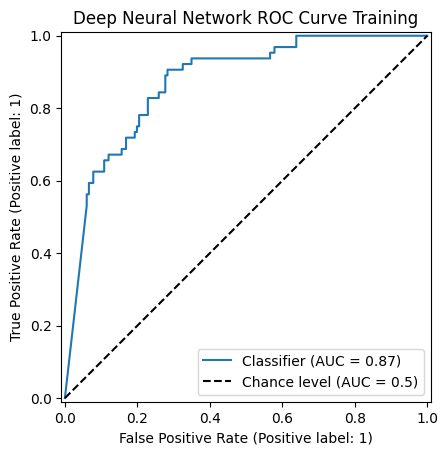

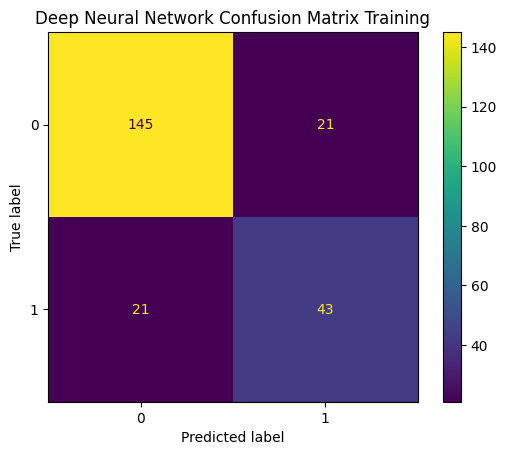

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       166
           1       0.67      0.67      0.67        64

    accuracy                           0.82       230
   macro avg       0.77      0.77      0.77       230
weighted avg       0.82      0.82      0.82       230

Mean accuracy (Validation): 0.85
Mean balanced accuracy(Validation):  0.7849462365591398
Mean roc auc(Validation):  0.8602150537634409


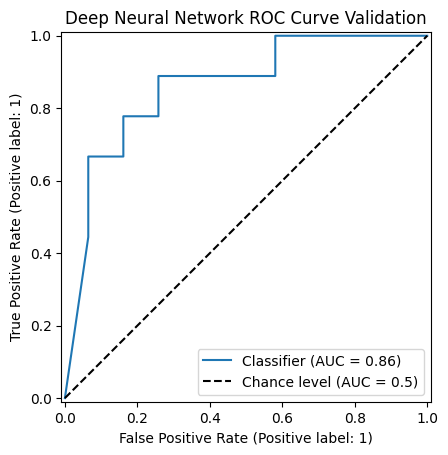

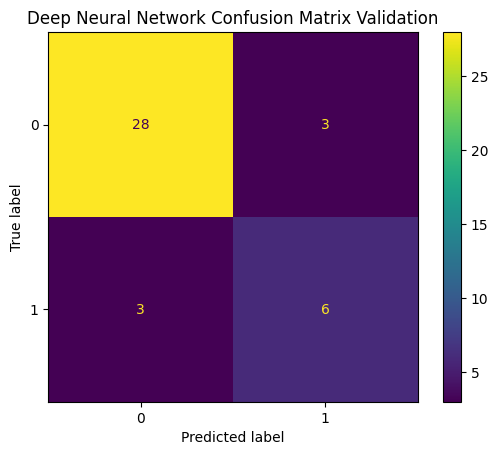

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        31
           1       0.67      0.67      0.67         9

    accuracy                           0.85        40
   macro avg       0.78      0.78      0.78        40
weighted avg       0.85      0.85      0.85        40


{'activation': 'identity',
 'alpha': 0.001,
 'early_stopping': True,
 'hidden_layer_sizes': (50, 50),
 'learning_rate_init': 0.001,
 'shuffle': True,
 'solver': 'adam'}

In [46]:
grid_cv_params_adam_1 = {
    'solver': ['adam'],
    'hidden_layer_sizes': [(100,), (50,50,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'alpha': [0.001], # strength of L2 regularization, higher - simpler model
    'learning_rate_init': [0.001], # lower - slower learning, but more precise
    'early_stopping': [True], # for 'sgd' and 'adam' only
    'shuffle': [True] # for 'sgd' and 'adam' only
}
grid_cv_res_adam_1 = grid_search_cv(mlp_params, grid_cv_params_adam_1)
grid_cv_res_adam_1.best_params_

Fitting 7 folds for each of 8 candidates, totalling 56 fits
Iteration 1, loss = 0.73257029
Validation score: 0.826087
Iteration 2, loss = 0.53591423
Validation score: 0.869565
Iteration 3, loss = 1.33447735
Validation score: 0.869565
Iteration 4, loss = 1.37002508
Validation score: 0.826087
Iteration 5, loss = 0.59273917
Validation score: 0.826087
Iteration 6, loss = 0.16578086
Validation score: 0.782609
Iteration 7, loss = 0.28844460
Validation score: 0.739130
Iteration 8, loss = 0.43641573
Validation score: 0.739130
Iteration 9, loss = 0.30925411
Validation score: 0.782609
Iteration 10, loss = 0.09473395
Validation score: 0.826087
Iteration 11, loss = 0.04407034
Validation score: 0.826087
Iteration 12, loss = 0.09180633
Validation score: 0.869565
Iteration 13, loss = 0.09258696
Validation score: 0.826087
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
_______________________________
Mean accuracy (Training): 0.7956521739130434
Mean balance

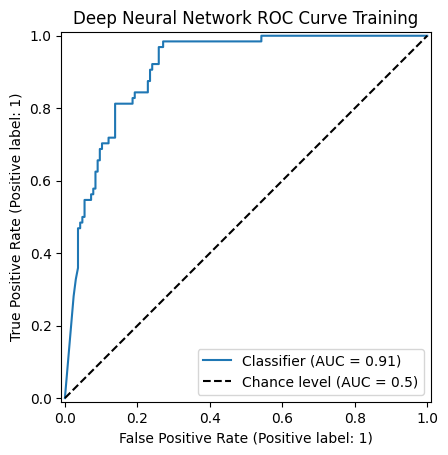

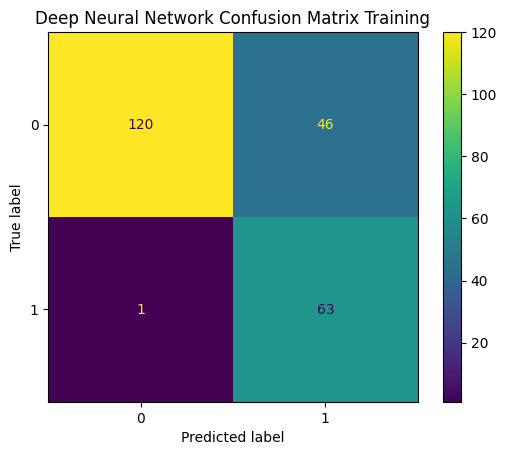

              precision    recall  f1-score   support

           0       0.99      0.72      0.84       166
           1       0.58      0.98      0.73        64

    accuracy                           0.80       230
   macro avg       0.78      0.85      0.78       230
weighted avg       0.88      0.80      0.81       230

Mean accuracy (Validation): 0.65
Mean balanced accuracy(Validation):  0.7347670250896057
Mean roc auc(Validation):  0.8440860215053763


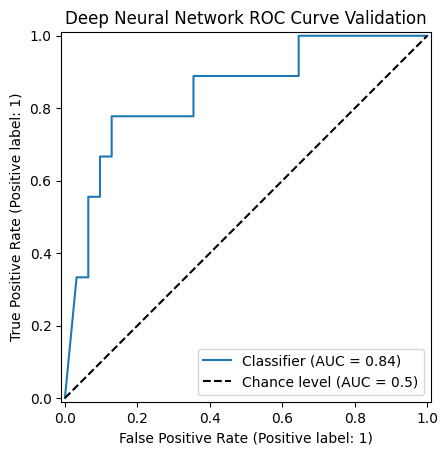

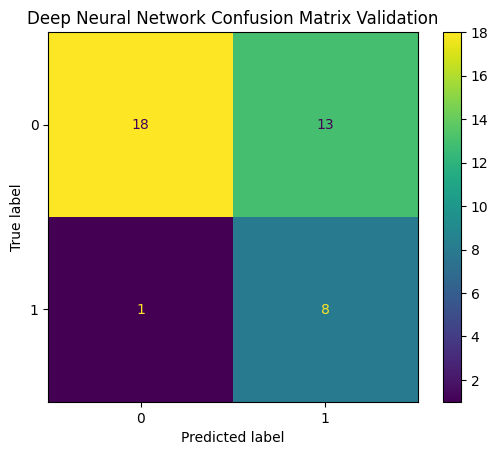

              precision    recall  f1-score   support

           0       0.95      0.58      0.72        31
           1       0.38      0.89      0.53         9

    accuracy                           0.65        40
   macro avg       0.66      0.73      0.63        40
weighted avg       0.82      0.65      0.68        40


{'activation': 'identity',
 'alpha': 0.001,
 'early_stopping': True,
 'hidden_layer_sizes': (50, 50),
 'learning_rate_init': 0.0001,
 'shuffle': True,
 'solver': 'adam'}

In [53]:
grid_cv_params_adam_2 = {
    'solver': ['adam'],
    'hidden_layer_sizes': [(50,50,)],
    'activation': ['identity'],
    'alpha': [0.001, 0.0001], # strength of L2 regularization, higher - simpler model
    'learning_rate_init': [0.001, 0.0001], # lower - slower learning, but more precise
    'early_stopping': [True], # for 'sgd' and 'adam' only
    'shuffle': [True, False] # for 'sgd' and 'adam' only
}
grid_cv_res_adam_2 = grid_search_cv(mlp_params, grid_cv_params_adam_2)
grid_cv_res_adam_2.best_params_

Fitting 7 folds for each of 2 candidates, totalling 14 fits
Iteration 1, loss = 0.64366151
Iteration 2, loss = 0.51869942
Iteration 3, loss = 0.46416934
Iteration 4, loss = 0.44184830
Iteration 5, loss = 0.40122324
Iteration 6, loss = 0.35541506
Iteration 7, loss = 0.33029646
Iteration 8, loss = 0.30348150
Iteration 9, loss = 0.27680298
Iteration 10, loss = 0.24962248
Iteration 11, loss = 0.22949418
Iteration 12, loss = 0.21563534
Iteration 13, loss = 0.20145329
Iteration 14, loss = 0.18791675
Iteration 15, loss = 0.17484378
Iteration 16, loss = 0.16178372
Iteration 17, loss = 0.15025763
Iteration 18, loss = 0.14204435
Iteration 19, loss = 0.13615909
Iteration 20, loss = 0.12956105
Iteration 21, loss = 0.12158759
Iteration 22, loss = 0.11383146
Iteration 23, loss = 0.10720495
Iteration 24, loss = 0.10302419
Iteration 25, loss = 0.09955698
Iteration 26, loss = 0.09403903
Iteration 27, loss = 0.08894885
Iteration 28, loss = 0.08479990
Iteration 29, loss = 0.08144894
Iteration 30, loss = 

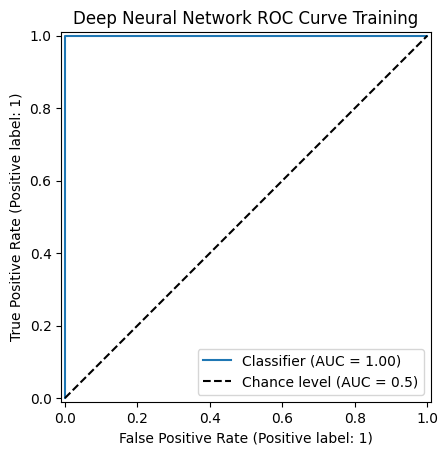

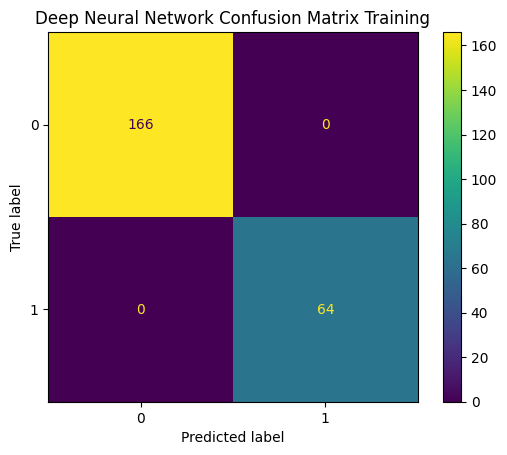

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00        64

    accuracy                           1.00       230
   macro avg       1.00      1.00      1.00       230
weighted avg       1.00      1.00      1.00       230

Mean accuracy (Validation): 0.8
Mean balanced accuracy(Validation):  0.6738351254480286
Mean roc auc(Validation):  0.8960573476702509


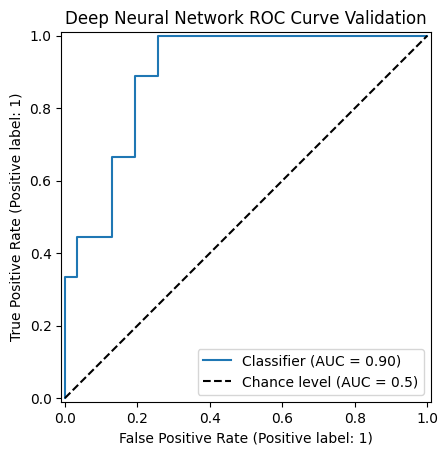

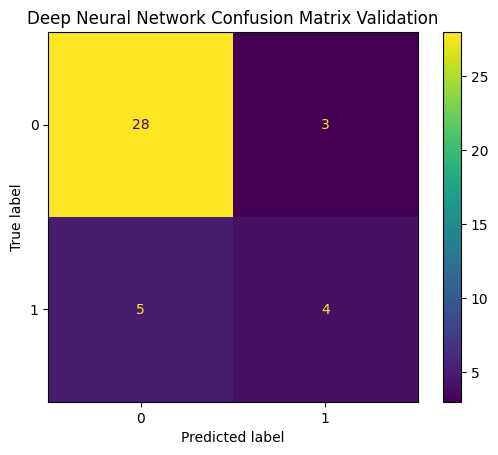

              precision    recall  f1-score   support

           0       0.85      0.90      0.88        31
           1       0.57      0.44      0.50         9

    accuracy                           0.80        40
   macro avg       0.71      0.67      0.69        40
weighted avg       0.79      0.80      0.79        40


{'activation': 'identity',
 'alpha': 0.0001,
 'early_stopping': False,
 'hidden_layer_sizes': (50, 50),
 'learning_rate_init': 1e-05,
 'shuffle': True,
 'solver': 'adam'}

In [55]:
grid_cv_params_adam_3 = {
    'solver': ['adam'],
    'hidden_layer_sizes': [(50,50,)],
    'activation': ['identity'],
    'alpha': [0.0001], # strength of L2 regularization, higher - simpler model
    'learning_rate_init': [0.00001], # lower - slower learning, but more precise
    'early_stopping': [True, False], # for 'sgd' and 'adam' only
    'shuffle': [True] # for 'sgd' and 'adam' only
}
grid_cv_res_adam_3 = grid_search_cv(mlp_params, grid_cv_params_adam_3)
grid_cv_res_adam_3.best_params_

Fitting 7 folds for each of 5 candidates, totalling 35 fits
Iteration 1, loss = 1.46962965
Validation score: 0.608696
Iteration 2, loss = 0.77360731
Validation score: 0.695652
Iteration 3, loss = 0.87450525
Validation score: 0.652174
Iteration 4, loss = 0.94859955
Validation score: 0.695652
Iteration 5, loss = 0.86360013
Validation score: 0.695652
Iteration 6, loss = 0.71566918
Validation score: 0.695652
Iteration 7, loss = 0.59606366
Validation score: 0.695652
Iteration 8, loss = 0.53945680
Validation score: 0.739130
Iteration 9, loss = 0.52712337
Validation score: 0.695652
Iteration 10, loss = 0.52097325
Validation score: 0.695652
Iteration 11, loss = 0.49973253
Validation score: 0.695652
Iteration 12, loss = 0.46554831
Validation score: 0.695652
Iteration 13, loss = 0.42337459
Validation score: 0.695652
Iteration 14, loss = 0.37911546
Validation score: 0.652174
Iteration 15, loss = 0.33945928
Validation score: 0.652174
Iteration 16, loss = 0.31542909
Validation score: 0.695652
Itera

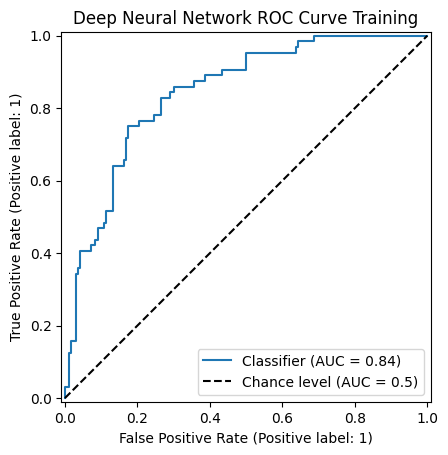

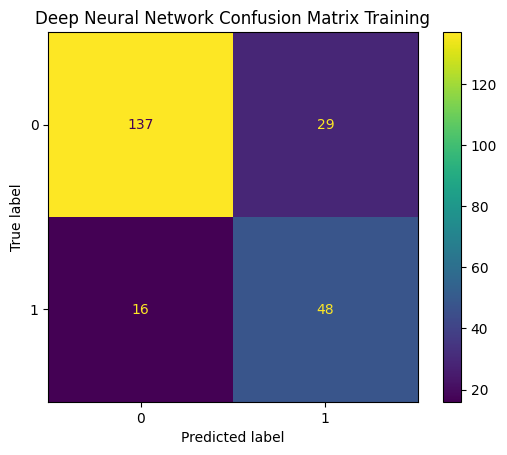

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       166
           1       0.62      0.75      0.68        64

    accuracy                           0.80       230
   macro avg       0.76      0.79      0.77       230
weighted avg       0.82      0.80      0.81       230

Mean accuracy (Validation): 0.825
Mean balanced accuracy(Validation):  0.7293906810035842
Mean roc auc(Validation):  0.8924731182795699


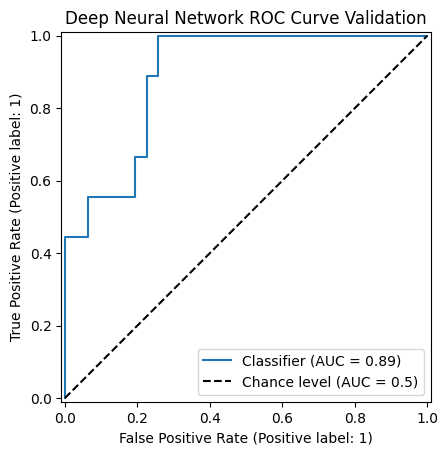

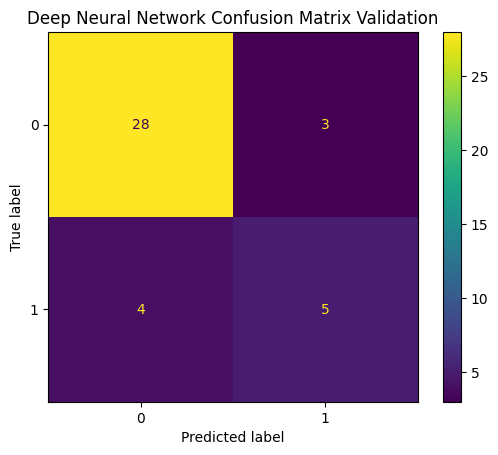

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        31
           1       0.62      0.56      0.59         9

    accuracy                           0.82        40
   macro avg       0.75      0.73      0.74        40
weighted avg       0.82      0.82      0.82        40


{'activation': 'identity',
 'alpha': 0.0001,
 'early_stopping': True,
 'hidden_layer_sizes': (50, 50),
 'learning_rate_init': 1e-05,
 'shuffle': True,
 'solver': 'adam'}

In [141]:
grid_cv_params_adam_4 = {
    'solver': ['adam'],
    'hidden_layer_sizes': [(70, 30),(50,50), (50,),(30, 20), (30,)],
    'activation': ['identity'],
    'alpha': [0.0001], # strength of L2 regularization, higher - simpler model
    'learning_rate_init': [0.00001], # lower - slower learning, but more precise
    'early_stopping': [True], # for 'sgd' and 'adam' only
    'shuffle': [True] # for 'sgd' and 'adam' only
}
grid_cv_res_adam_4 = grid_search_cv(mlp_params, grid_cv_params_adam_4)
grid_cv_res_adam_4.best_params_

Fitting 7 folds for each of 5 candidates, totalling 35 fits
Iteration 1, loss = 2.12276855
Iteration 2, loss = 0.86399406
Iteration 3, loss = 0.81252345
Iteration 4, loss = 0.83011458
Iteration 5, loss = 0.78950354
Iteration 6, loss = 0.70518473
Iteration 7, loss = 0.60747535
Iteration 8, loss = 0.53515020
Iteration 9, loss = 0.48477169
Iteration 10, loss = 0.46426001
Iteration 11, loss = 0.44636973
Iteration 12, loss = 0.42664041
Iteration 13, loss = 0.40199480
Iteration 14, loss = 0.36992693
Iteration 15, loss = 0.33686665
Iteration 16, loss = 0.30589721
Iteration 17, loss = 0.28539083
Iteration 18, loss = 0.27165220
Iteration 19, loss = 0.26104564
Iteration 20, loss = 0.25094543
Iteration 21, loss = 0.23568252
Iteration 22, loss = 0.21754506
Iteration 23, loss = 0.20283033
Iteration 24, loss = 0.19284101
Iteration 25, loss = 0.18764307
Iteration 26, loss = 0.18189926
Iteration 27, loss = 0.17335543
Iteration 28, loss = 0.16269783
Iteration 29, loss = 0.15399887
Iteration 30, loss = 

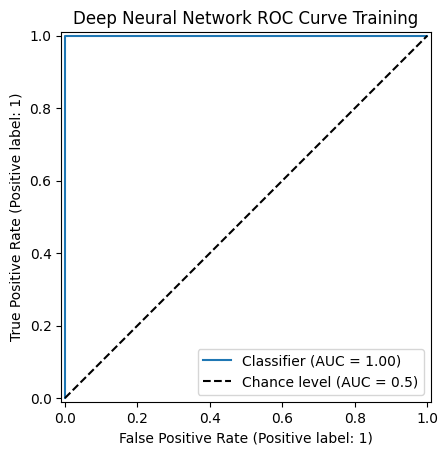

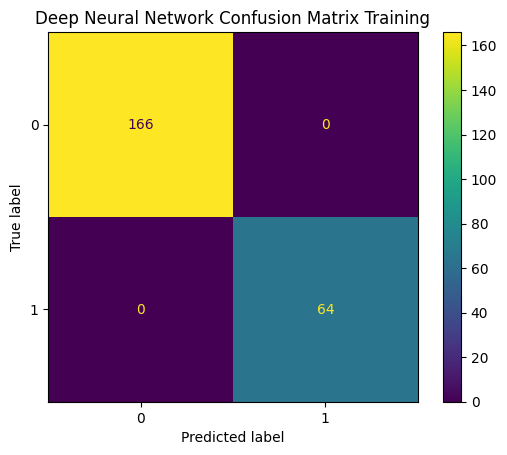

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00        64

    accuracy                           1.00       230
   macro avg       1.00      1.00      1.00       230
weighted avg       1.00      1.00      1.00       230

Mean accuracy (Validation): 0.825
Mean balanced accuracy(Validation):  0.6505376344086021
Mean roc auc(Validation):  0.8100358422939068


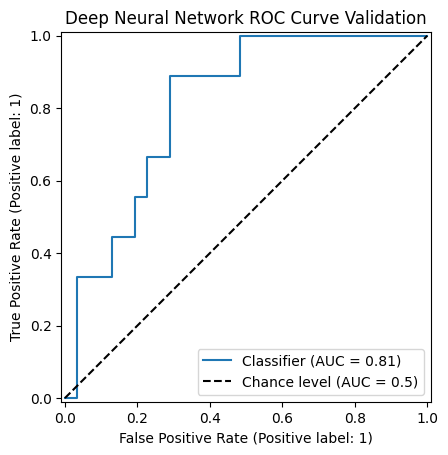

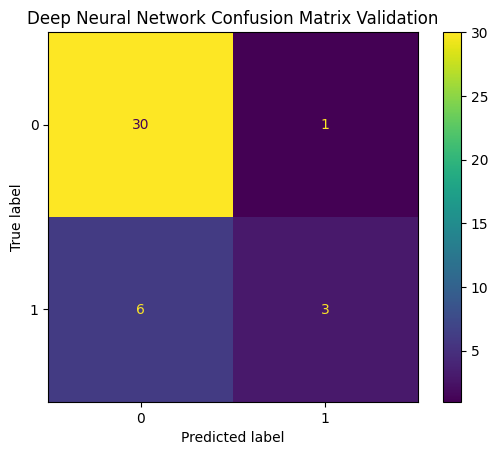

              precision    recall  f1-score   support

           0       0.83      0.97      0.90        31
           1       0.75      0.33      0.46         9

    accuracy                           0.82        40
   macro avg       0.79      0.65      0.68        40
weighted avg       0.81      0.82      0.80        40


{'activation': 'identity',
 'alpha': 0.0001,
 'early_stopping': False,
 'hidden_layer_sizes': (30,),
 'learning_rate_init': 1e-05,
 'shuffle': True,
 'solver': 'adam'}

In [142]:
grid_cv_params_adam_5 = {
    'solver': ['adam'],
    'hidden_layer_sizes': [(70, 30),(50,),(50,50), (30, 20), (30,)],
    'activation': ['identity'],
    'alpha': [0.0001], # strength of L2 regularization, higher - simpler model
    'learning_rate_init': [0.00001], # lower - slower learning, but more precise
    'early_stopping': [False], # for 'sgd' and 'adam' only
    'shuffle': [True] # for 'sgd' and 'adam' only
}
grid_cv_res_adam_5 = grid_search_cv(mlp_params, grid_cv_params_adam_5)
grid_cv_res_adam_5.best_params_

Fitting 7 folds for each of 9 candidates, totalling 63 fits
Iteration 1, loss = 2.15328851
Iteration 2, loss = 3.16639308
Iteration 3, loss = 2.67611603
Iteration 4, loss = 1.09413339
Iteration 5, loss = 0.97850315
Iteration 6, loss = 1.28135200
Iteration 7, loss = 1.18321305
Iteration 8, loss = 0.75528500
Iteration 9, loss = 0.28230230
Iteration 10, loss = 0.27023443
Iteration 11, loss = 0.46606147
Iteration 12, loss = 0.29739546
Iteration 13, loss = 0.09052062
Iteration 14, loss = 0.05493949
Iteration 15, loss = 0.09567072
Iteration 16, loss = 0.13109019
Iteration 17, loss = 0.10696600
Iteration 18, loss = 0.03646657
Iteration 19, loss = 0.01551813
Iteration 20, loss = 0.01838372
Iteration 21, loss = 0.02877399
Iteration 22, loss = 0.04115517
Iteration 23, loss = 0.03794243
Iteration 24, loss = 0.02378318
Iteration 25, loss = 0.01423180
Iteration 26, loss = 0.00938728
Iteration 27, loss = 0.00708006
Iteration 28, loss = 0.00623781
Iteration 29, loss = 0.00573441
Iteration 30, loss = 

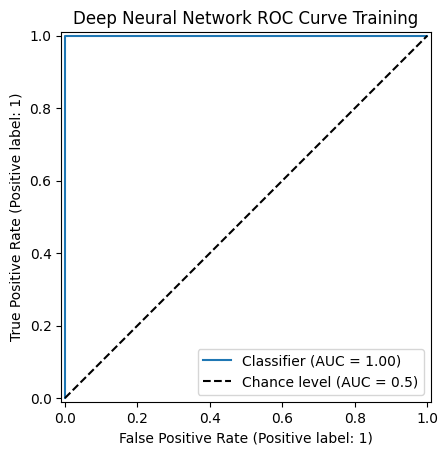

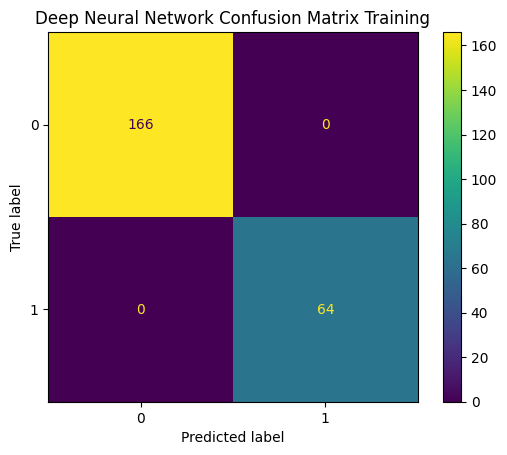

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00        64

    accuracy                           1.00       230
   macro avg       1.00      1.00      1.00       230
weighted avg       1.00      1.00      1.00       230

Mean accuracy (Validation): 0.85
Mean balanced accuracy(Validation):  0.7060931899641577
Mean roc auc(Validation):  0.867383512544803


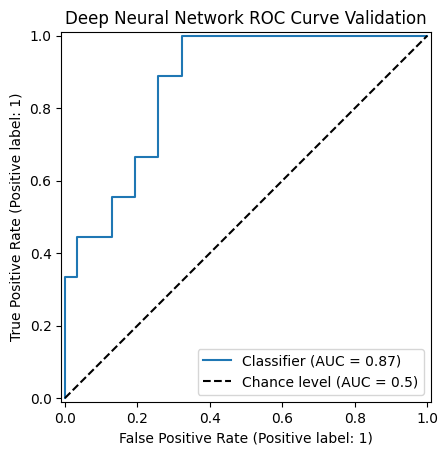

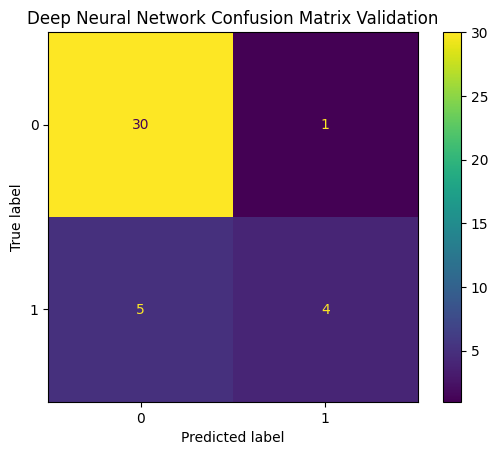

              precision    recall  f1-score   support

           0       0.86      0.97      0.91        31
           1       0.80      0.44      0.57         9

    accuracy                           0.85        40
   macro avg       0.83      0.71      0.74        40
weighted avg       0.84      0.85      0.83        40


{'activation': 'identity',
 'alpha': 0.001,
 'early_stopping': False,
 'hidden_layer_sizes': (30,),
 'learning_rate_init': 0.0001,
 'shuffle': True,
 'solver': 'adam'}

In [145]:
grid_cv_params_adam_6 = {
    'solver': ['adam'],
    'hidden_layer_sizes': [(30,)],
    'activation': ['identity'],
    'alpha': [0.001, 0.0001, 0.00001], # strength of L2 regularization, higher - simpler model
    'learning_rate_init': [0.0001, 0.00001, 0.000001], # lower - slower learning, but more precise
    'early_stopping': [False], # for 'sgd' and 'adam' only
    'shuffle': [True] # for 'sgd' and 'adam' only
}
grid_cv_res_adam_6 = grid_search_cv(mlp_params, grid_cv_params_adam_6)
grid_cv_res_adam_6.best_params_

Fitting 7 folds for each of 9 candidates, totalling 63 fits
Iteration 1, loss = 2.14974542
Iteration 2, loss = 0.89099754
Iteration 3, loss = 0.83953351
Iteration 4, loss = 0.85710582
Iteration 5, loss = 0.81648038
Iteration 6, loss = 0.73215223
Iteration 7, loss = 0.63443371
Iteration 8, loss = 0.56209678
Iteration 9, loss = 0.51170528
Iteration 10, loss = 0.49118961
Iteration 11, loss = 0.47329605
Iteration 12, loss = 0.45356009
Iteration 13, loss = 0.42890407
Iteration 14, loss = 0.39682493
Iteration 15, loss = 0.36375389
Iteration 16, loss = 0.33277607
Iteration 17, loss = 0.31226451
Iteration 18, loss = 0.29852175
Iteration 19, loss = 0.28790994
Iteration 20, loss = 0.27779986
Iteration 21, loss = 0.26252429
Iteration 22, loss = 0.24437659
Iteration 23, loss = 0.22965621
Iteration 24, loss = 0.21966432
Iteration 25, loss = 0.21446207
Iteration 26, loss = 0.20870898
Iteration 27, loss = 0.20015382
Iteration 28, loss = 0.18948587
Iteration 29, loss = 0.18077992
Iteration 30, loss = 

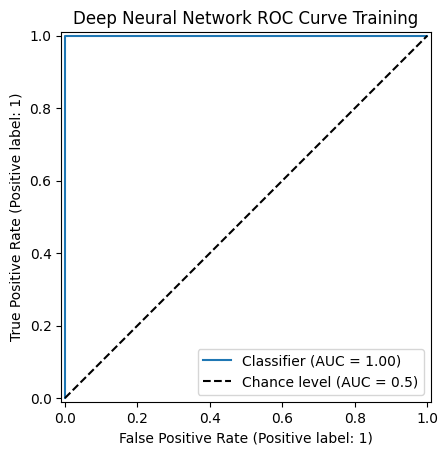

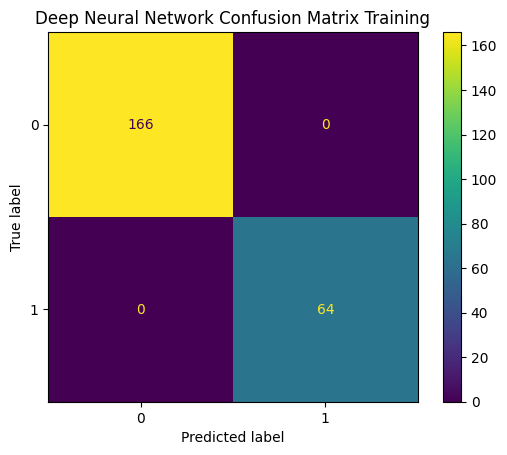

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00        64

    accuracy                           1.00       230
   macro avg       1.00      1.00      1.00       230
weighted avg       1.00      1.00      1.00       230

Mean accuracy (Validation): 0.825
Mean balanced accuracy(Validation):  0.6505376344086021
Mean roc auc(Validation):  0.8100358422939068


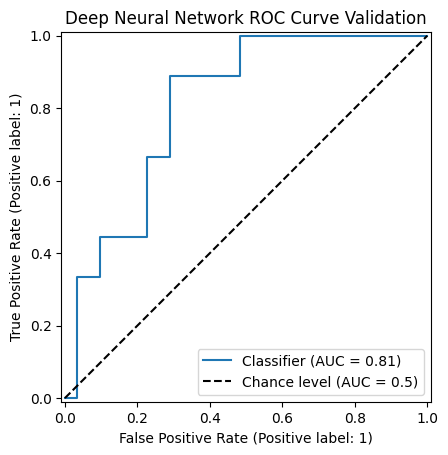

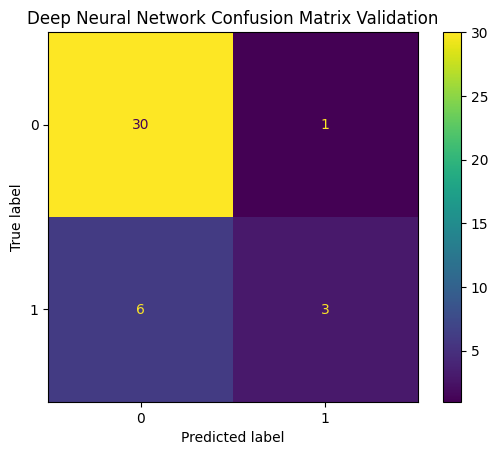

              precision    recall  f1-score   support

           0       0.83      0.97      0.90        31
           1       0.75      0.33      0.46         9

    accuracy                           0.82        40
   macro avg       0.79      0.65      0.68        40
weighted avg       0.81      0.82      0.80        40


{'activation': 'identity',
 'alpha': 0.1,
 'early_stopping': False,
 'hidden_layer_sizes': (30,),
 'learning_rate_init': 1e-05,
 'shuffle': True,
 'solver': 'adam'}

In [152]:
grid_cv_params_adam_7 = {
    'solver': ['adam'],
    'hidden_layer_sizes': [(30,), (20,), (10,)],
    'activation': ['identity'],
    'alpha': [0.1, 0.01, 0.001], # strength of L2 regularization, higher - simpler model
    'learning_rate_init': [0.00001], # lower - slower learning, but more precise
    'early_stopping': [False], # for 'sgd' and 'adam' only
    'shuffle': [True] # for 'sgd' and 'adam' only
}
grid_cv_res_adam_7 = grid_search_cv(mlp_params, grid_cv_params_adam_7)
grid_cv_res_adam_7.best_params_

Fitting 7 folds for each of 6 candidates, totalling 42 fits
Iteration 1, loss = 1.25557479
Iteration 2, loss = 0.66714312
Iteration 3, loss = 0.74305433
Iteration 4, loss = 0.46778321
Iteration 5, loss = 0.30678340
Iteration 6, loss = 0.20329982
Iteration 7, loss = 0.12151601
Iteration 8, loss = 0.08106756
Iteration 9, loss = 0.06204557
Iteration 10, loss = 0.04916013
Iteration 11, loss = 0.04251413
Iteration 12, loss = 0.03933769
Iteration 13, loss = 0.03910218
Iteration 14, loss = 0.03610496
Iteration 15, loss = 0.03246007
Iteration 16, loss = 0.03045756
Iteration 17, loss = 0.02872993
Iteration 18, loss = 0.02762869
Iteration 19, loss = 0.02668326
Iteration 20, loss = 0.02586871
Iteration 21, loss = 0.02520265
Iteration 22, loss = 0.02458148
Iteration 23, loss = 0.02405355
Iteration 24, loss = 0.02359394
Iteration 25, loss = 0.02316659
Iteration 26, loss = 0.02277326
Iteration 27, loss = 0.02242426
Iteration 28, loss = 0.02214247
Iteration 29, loss = 0.02185900
Iteration 30, loss = 

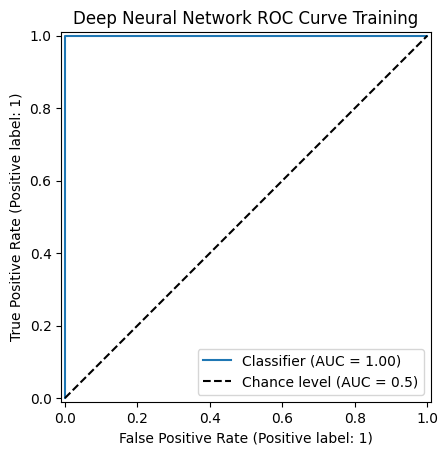

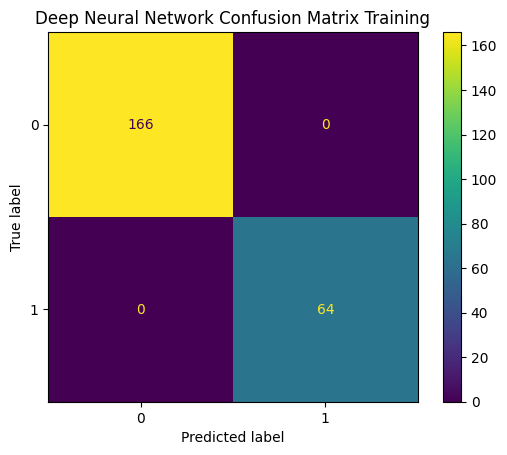

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00        64

    accuracy                           1.00       230
   macro avg       1.00      1.00      1.00       230
weighted avg       1.00      1.00      1.00       230

Mean accuracy (Validation): 0.825
Mean balanced accuracy(Validation):  0.6899641577060931
Mean roc auc(Validation):  0.9032258064516129


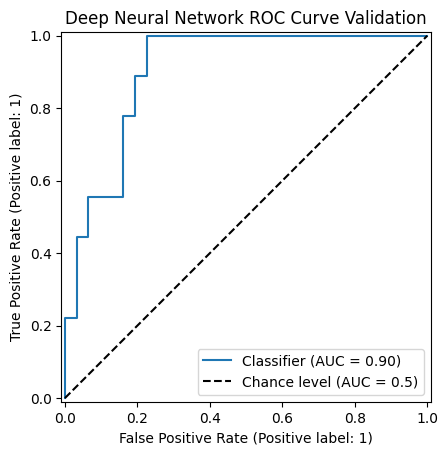

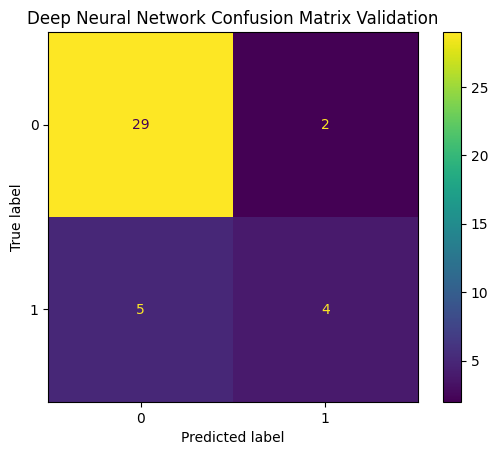

              precision    recall  f1-score   support

           0       0.85      0.94      0.89        31
           1       0.67      0.44      0.53         9

    accuracy                           0.82        40
   macro avg       0.76      0.69      0.71        40
weighted avg       0.81      0.82      0.81        40


{'activation': 'identity',
 'alpha': 0.1,
 'early_stopping': False,
 'hidden_layer_sizes': (20,),
 'learning_rate_init': 0.0001,
 'shuffle': True,
 'solver': 'adam'}

In [154]:
grid_cv_params_adam_8 = {
    'solver': ['adam'],
    'hidden_layer_sizes': [(20,), (10,)],
    'activation': ['identity'],
    'alpha': [0.1], # strength of L2 regularization, higher - simpler model
    'learning_rate_init': [0.0001,0.00001, 0.000001], # lower - slower learning, but more precise
    'early_stopping': [False], # for 'sgd' and 'adam' only
    'shuffle': [True] # for 'sgd' and 'adam' only
}
grid_cv_res_adam_8 = grid_search_cv(mlp_params, grid_cv_params_adam_8)
grid_cv_res_adam_8.best_params_

### Grid Search CV for optimizer (`solver`) Limited-memory Broyden–Fletcher–Goldfarb–Shanno (LBFGS)

Fitting 7 folds for each of 8 candidates, totalling 56 fits
_______________________________
Mean accuracy (Training): 1.0
Mean balanced accuracy(Training):  1.0
Mean roc auc(Training):  1.0


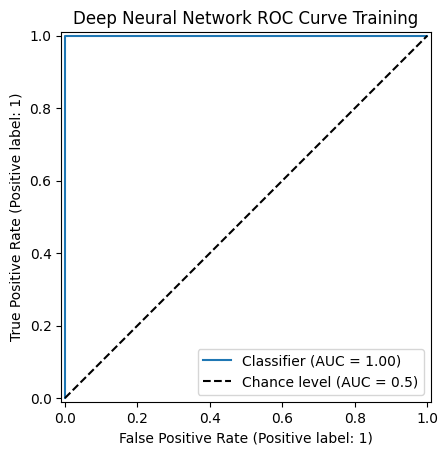

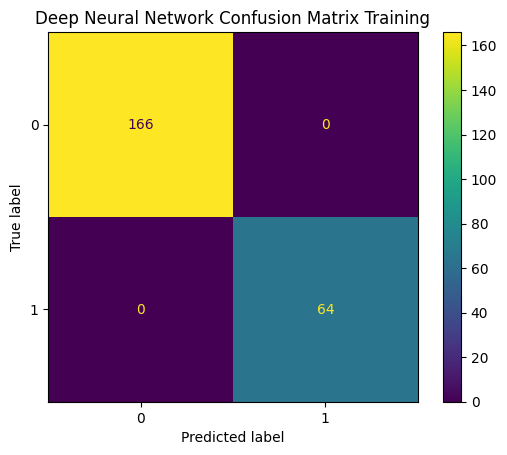

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00        64

    accuracy                           1.00       230
   macro avg       1.00      1.00      1.00       230
weighted avg       1.00      1.00      1.00       230

Mean accuracy (Validation): 0.825
Mean balanced accuracy(Validation):  0.7293906810035842
Mean roc auc(Validation):  0.8924731182795698


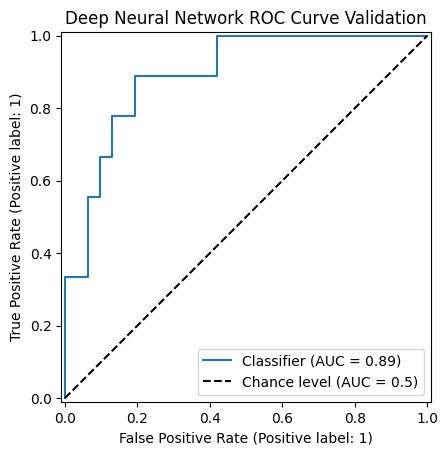

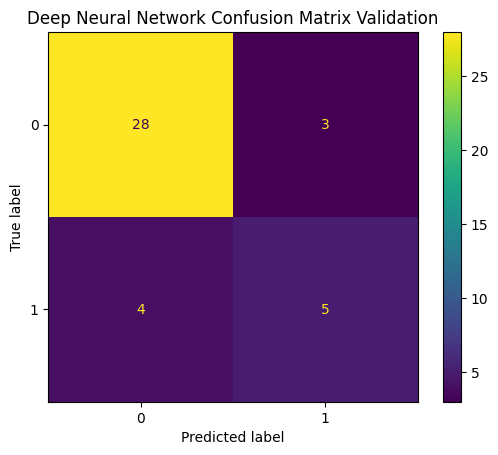

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        31
           1       0.62      0.56      0.59         9

    accuracy                           0.82        40
   macro avg       0.75      0.73      0.74        40
weighted avg       0.82      0.82      0.82        40


{'activation': 'identity',
 'alpha': 0.001,
 'hidden_layer_sizes': (100,),
 'solver': 'lbfgs'}

In [54]:
grid_cv_params_lbfgs_1 = {
    'solver': ['lbfgs'],
    'hidden_layer_sizes': [(100,), (50,50,)],
    'alpha': [0.001], # strength of L2 regularization, higher - simpler model 
    'activation': ['identity', 'logistic', 'tanh', 'relu'],    
}
grid_cv_res_lbfgs_1 = grid_search_cv(mlp_params, grid_cv_params_lbfgs_1)
grid_cv_res_lbfgs_1.best_params_

Adjusting the alpha param

Fitting 7 folds for each of 12 candidates, totalling 84 fits
_______________________________
Mean accuracy (Training): 1.0
Mean balanced accuracy(Training):  1.0
Mean roc auc(Training):  1.0


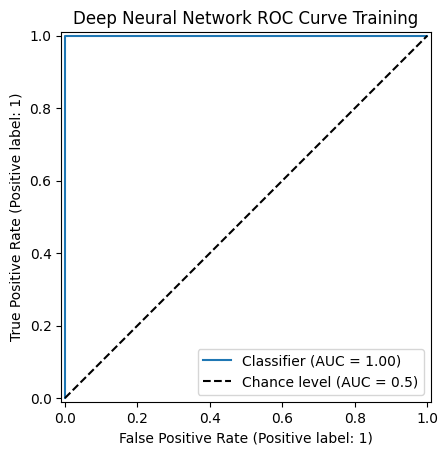

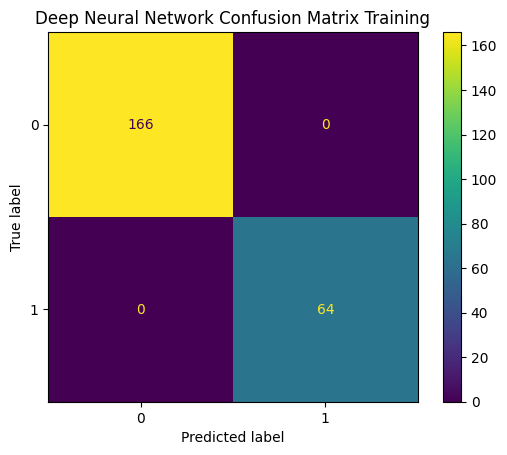

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00        64

    accuracy                           1.00       230
   macro avg       1.00      1.00      1.00       230
weighted avg       1.00      1.00      1.00       230

Mean accuracy (Validation): 0.875
Mean balanced accuracy(Validation):  0.7222222222222222
Mean roc auc(Validation):  0.8745519713261649


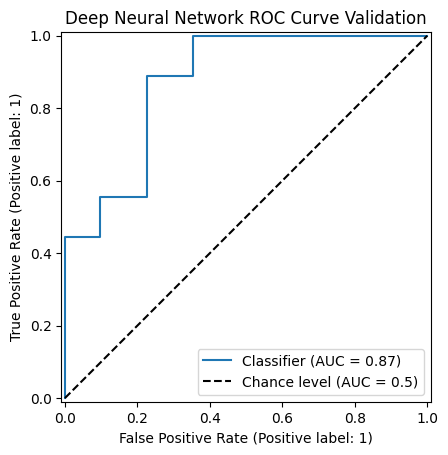

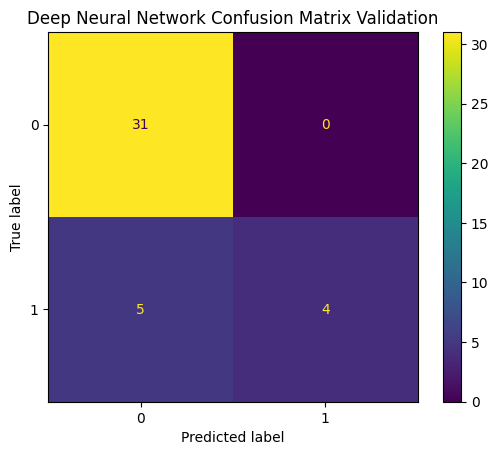

              precision    recall  f1-score   support

           0       0.86      1.00      0.93        31
           1       1.00      0.44      0.62         9

    accuracy                           0.88        40
   macro avg       0.93      0.72      0.77        40
weighted avg       0.89      0.88      0.86        40


{'activation': 'identity',
 'alpha': 0.01,
 'hidden_layer_sizes': (30,),
 'solver': 'lbfgs'}

In [136]:
grid_cv_params_lbfgs_2 = {
    'solver': ['lbfgs'],
    'hidden_layer_sizes': [(100,), (50,), (30, )],
    'alpha': [0.1, 0.01,0.001, 0.0001], # strength of L2 regularization, higher - simpler model 
    'activation': ['identity'],    
}
grid_cv_res_lbfgs_2 = grid_search_cv(mlp_params, grid_cv_params_lbfgs_2)
grid_cv_res_lbfgs_2.best_params_

Fitting 7 folds for each of 9 candidates, totalling 63 fits
_______________________________
Mean accuracy (Training): 1.0
Mean balanced accuracy(Training):  1.0
Mean roc auc(Training):  1.0


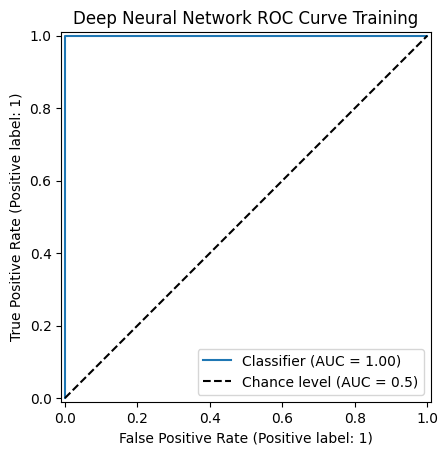

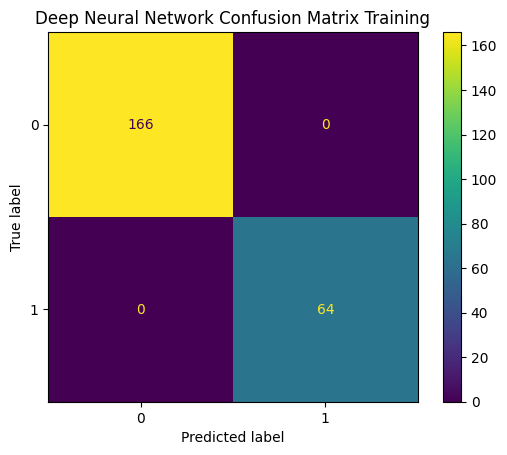

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00        64

    accuracy                           1.00       230
   macro avg       1.00      1.00      1.00       230
weighted avg       1.00      1.00      1.00       230

Mean accuracy (Validation): 0.85
Mean balanced accuracy(Validation):  0.7455197132616487
Mean roc auc(Validation):  0.8853046594982079


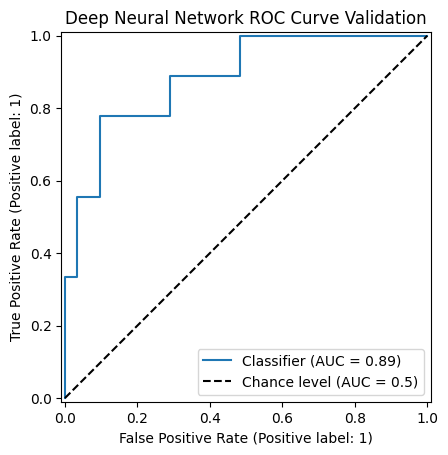

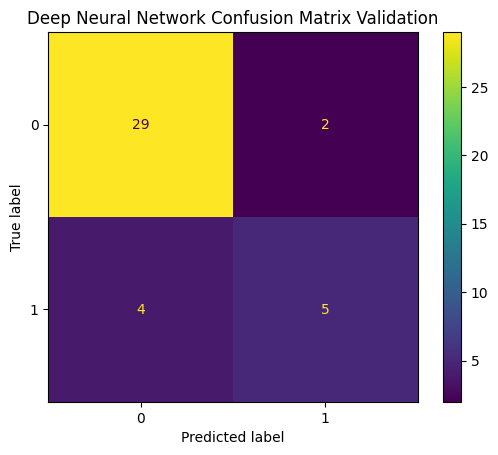

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        31
           1       0.71      0.56      0.62         9

    accuracy                           0.85        40
   macro avg       0.80      0.75      0.77        40
weighted avg       0.84      0.85      0.84        40


{'activation': 'identity',
 'alpha': 0.1,
 'hidden_layer_sizes': (40,),
 'solver': 'lbfgs'}

In [137]:
grid_cv_params_lbfgs_3 = {
    'solver': ['lbfgs'],
    'hidden_layer_sizes': [(40,), (30,), (20,)],
    'alpha': [0.1, 0.01, 0.001], # strength of L2 regularization, higher - simpler model
    'activation': ['identity'],
    
}
grid_cv_res_lbfgs_3 = grid_search_cv(mlp_params, grid_cv_params_lbfgs_3)
grid_cv_res_lbfgs_3.best_params_


### Grid Search CV for optimizer (`solver`): Stochastic Gradient Descent (SGD)

Fitting 7 folds for each of 24 candidates, totalling 168 fits
Iteration 1, loss = 1.22657727
Validation score: 0.739130
Iteration 2, loss = 2.13764253
Validation score: 0.739130
Iteration 3, loss = 3.04085997
Validation score: 0.739130
Iteration 4, loss = 3.30529260
Validation score: 0.739130
Iteration 5, loss = 3.42745429
Validation score: 0.739130
Iteration 6, loss = 3.43129434
Validation score: 0.739130
Iteration 7, loss = 3.39098215
Validation score: 0.739130
Iteration 8, loss = 3.29764294
Validation score: 0.739130
Iteration 9, loss = 3.17164684
Validation score: 0.739130
Iteration 10, loss = 3.01975968
Validation score: 0.739130
Iteration 11, loss = 2.86275399
Validation score: 0.739130
Iteration 12, loss = 2.69265107
Validation score: 0.739130
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
_______________________________
Mean accuracy (Training): 0.7217391304347827
Mean balanced accuracy(Training):  0.5
Mean roc auc(Training):  0.589

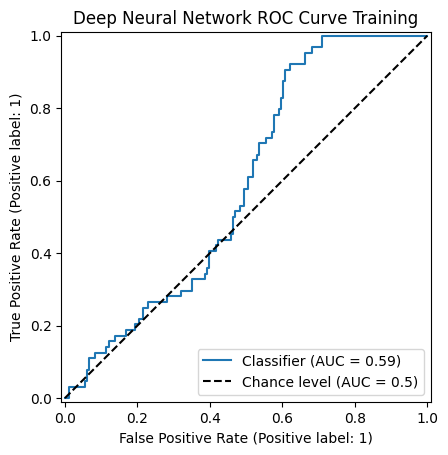

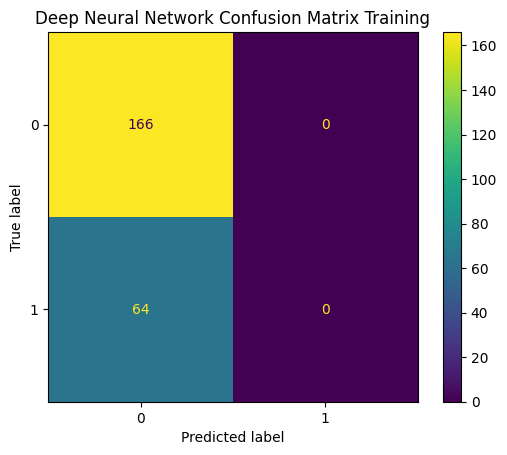

              precision    recall  f1-score   support

           0       0.72      1.00      0.84       166
           1       0.00      0.00      0.00        64

    accuracy                           0.72       230
   macro avg       0.36      0.50      0.42       230
weighted avg       0.52      0.72      0.61       230

Mean accuracy (Validation): 0.775
Mean balanced accuracy(Validation):  0.5
Mean roc auc(Validation):  0.6415770609318996


C:\Users\zofia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zofia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zofia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

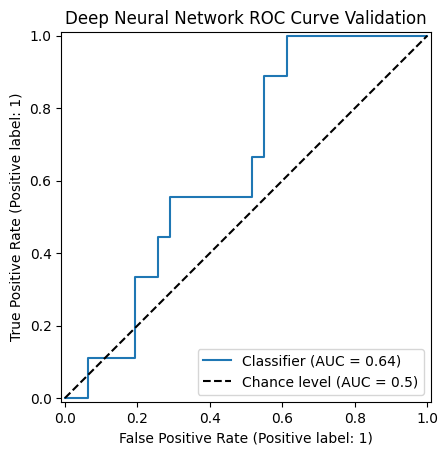

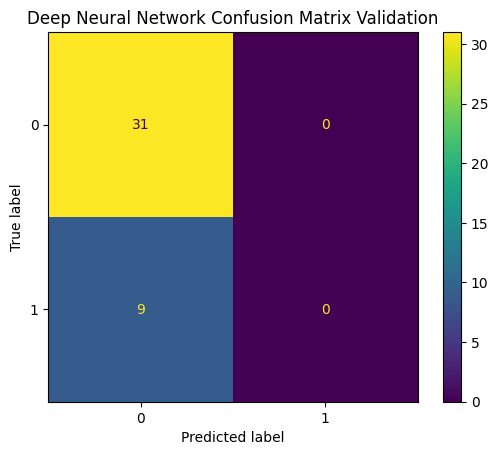

              precision    recall  f1-score   support

           0       0.78      1.00      0.87        31
           1       0.00      0.00      0.00         9

    accuracy                           0.78        40
   macro avg       0.39      0.50      0.44        40
weighted avg       0.60      0.78      0.68        40


C:\Users\zofia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zofia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zofia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

{'activation': 'relu',
 'alpha': 0.001,
 'early_stopping': True,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'invscaling',
 'momentum': 0.9,
 'shuffle': True,
 'solver': 'sgd'}

In [50]:
grid_cv_params_sgd_1 = {
    'solver': ['sgd'],
    'hidden_layer_sizes': [(100,), (50,50,)],
    'alpha': [0.001], # strength of L2 regularization, higher - simpler model
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'], # for SGD only
    'early_stopping': [True], # for 'sgd' and 'adam' only
    'shuffle': [True], # for 'sgd' and 'adam' only
    'momentum':[0.9]
}
grid_cv_res_sgd_1 = grid_search_cv(mlp_params, grid_cv_params_sgd_1)
grid_cv_res_sgd_1.best_params_

Fitting 7 folds for each of 12 candidates, totalling 84 fits
Iteration 1, loss = 2.10575925
Iteration 2, loss = 4.36976965
Iteration 3, loss = 4.41900357
Iteration 4, loss = 4.42986477
Iteration 5, loss = 4.43429539
Iteration 6, loss = 4.43462435
Iteration 7, loss = 4.43403547
Iteration 8, loss = 4.43299191
Iteration 9, loss = 4.43096107
Iteration 10, loss = 4.42853922
Iteration 11, loss = 4.42517508
Iteration 12, loss = 4.42276161
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
_______________________________
Mean accuracy (Training): 0.7217391304347827
Mean balanced accuracy(Training):  0.5
Mean roc auc(Training):  0.5027296686746987


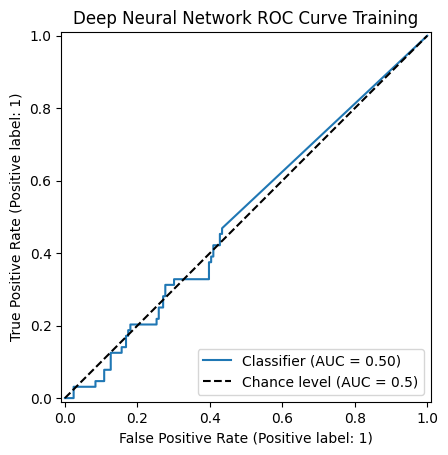

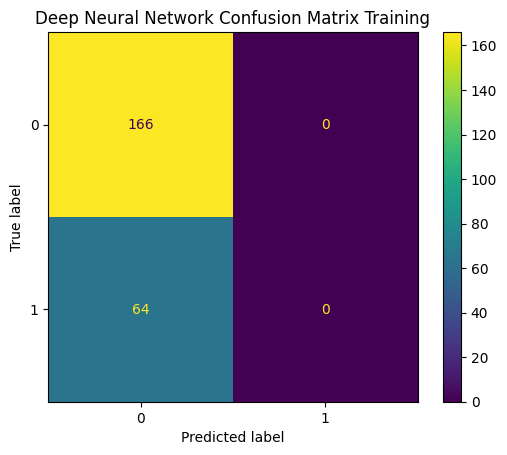

              precision    recall  f1-score   support

           0       0.72      1.00      0.84       166
           1       0.00      0.00      0.00        64

    accuracy                           0.72       230
   macro avg       0.36      0.50      0.42       230
weighted avg       0.52      0.72      0.61       230

Mean accuracy (Validation): 0.775
Mean balanced accuracy(Validation):  0.5
Mean roc auc(Validation):  0.6200716845878136


C:\Users\zofia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zofia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zofia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

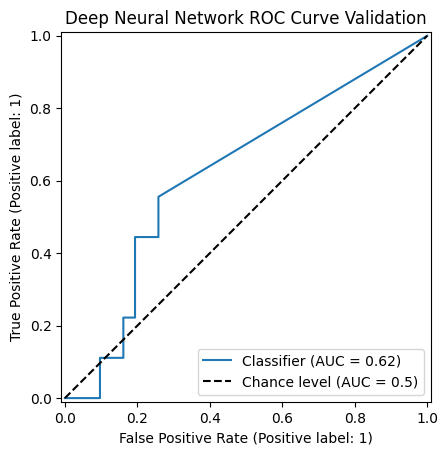

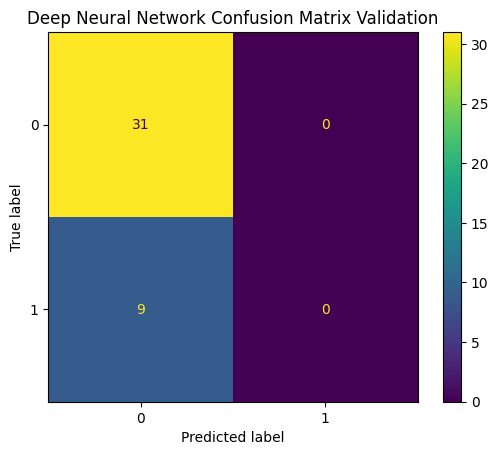

              precision    recall  f1-score   support

           0       0.78      1.00      0.87        31
           1       0.00      0.00      0.00         9

    accuracy                           0.78        40
   macro avg       0.39      0.50      0.44        40
weighted avg       0.60      0.78      0.68        40


C:\Users\zofia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zofia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zofia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

{'activation': 'identity',
 'alpha': 0.001,
 'early_stopping': False,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'invscaling',
 'momentum': 0.7,
 'shuffle': True,
 'solver': 'sgd'}

In [101]:
grid_cv_params_sgd_2 = {
    'solver': ['sgd'],
    'hidden_layer_sizes': [(100,)],
    'alpha': [0.001, 0.0001], # strength of L2 regularization, higher - simpler model
    'activation': ['identity', 'relu'],
    'learning_rate': ['invscaling'], # for SGD only
    'early_stopping': [False], # for 'sgd' and 'adam' only
    'shuffle': [True], # for 'sgd' and 'adam' only
    'momentum':[0.5, 0.7, 0.9]
}
grid_cv_res_sgd_2 = grid_search_cv(mlp_params, grid_cv_params_sgd_2)
grid_cv_res_sgd_2.best_params_

## Chosen model
Create a model with chosen params

In [163]:
chosen_model = grid_cv_res_lbfgs_2.best_estimator_

In [177]:
chosen_model_params = {**grid_cv_res_lbfgs_2.best_params_, **mlp_params}
chosen_model_params

{'activation': 'identity',
 'alpha': 0.01,
 'hidden_layer_sizes': (30,),
 'solver': 'lbfgs',
 'random_state': RandomState(MT19937) at 0x21752B60040,
 'batch_size': 'auto',
 'warm_start': True,
 'max_iter': 500,
 'verbose': 2}

Save the chosen model

In [172]:
joblib.dump(chosen_model, os.path.join(os.pardir, 'models', 'dnn_model.joblib'))

['..\\models\\dnn_model.joblib']

## Check test results
Download the model if is not defined

In [4]:
if 'chosen_model' not in globals():
    chosen_model=joblib.load(os.path.join(os.pardir, 'models', 'dnn_model.joblib'), 'r')

Define a test function

In [11]:
def dnn_classifier_test(svc, X_test_csr, y_test) -> None:
    y_test_pred = svc.predict(X_test_csr)
    y_test_pred_proba = svc.predict_proba(X_test_csr)[:,1]
    classifier_results("DNN", "Independent Testing", y_test, y_test_pred, y_test_pred_proba)

Load the test data

In [12]:
store = pd.HDFStore(os.path.join(os.pardir, 'data', 'ctc_split_datasets.h5'), mode='r')

X_test, y_test = store["X_test"], store["y_test"]
X_test_csr = csr_matrix(X_test.astype(np.float32))

store.close()
del store

Check results on test data

Mean accuracy (Independent Testing): 0.8378378378378378
Mean balanced accuracy(Independent Testing):  0.625
Mean roc auc(Independent Testing):  0.8362068965517242


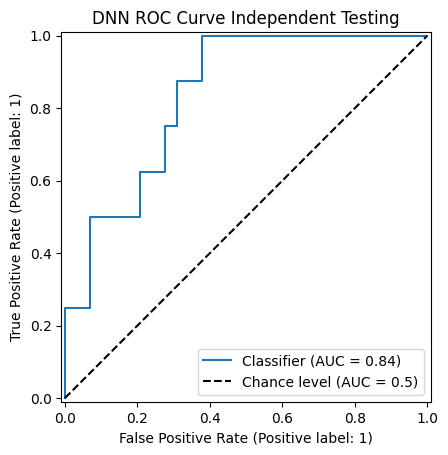

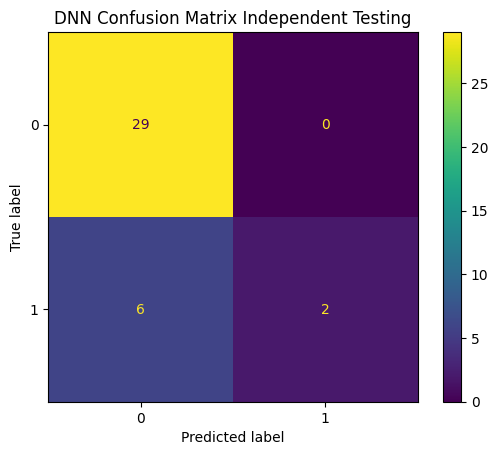

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        29
           1       1.00      0.25      0.40         8

    accuracy                           0.84        37
   macro avg       0.91      0.62      0.65        37
weighted avg       0.87      0.84      0.80        37


In [13]:
dnn_classifier_test(chosen_model, X_test_csr, y_test)